# Visual Autolabel Project


**Authors**: [Shaoling Chen](mailto:sc6995@nyu.edu) and [Noah C. Benson](mailto:nben@nyu.edu)  
**Date**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Feb. 7, 2020  
**Link**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [noahbenson/visual-autolabel](https://github.com/noahbenson/visual-autolabel)


## Introduction

This notebook is intended as a both a space for notes/documentation and code snippets related to the visual autolabel project. This project seeks to automatically label the vertices of the occipital cortex as members of V1, V2, V3, or none of these. This task is performed by examining the retinotopic maps of a subject and determining where the visual area boundaries are based on features such as polar-angle reversals.

### Problem Statement

In attempting to solve this problem, we should start by defining the problem more clearly.

#### The Inputs

* Let $M = (V,F)$ be a [triangle mesh](https://en.wikipedia.org/wiki/Triangle_mesh) representing the cortical surface with a vertex-set $V$ and a set of faces $F = \{(a,b,c)$ where $a,b,c\in V$ are the corner vertices of a tringle in the mesh$\}$. Additionally note that $a$, $b$, and $c$ are always in counter-clockwise ordering relative to the outward-facing vertex normals of the (cotical surface) triangle mesh.
* Let $E$ be the set of undirected edges implicit in $F$, and let $G = (V,E)$ be, equivalently, a graph that is the equivalent of the triangle mesh. Explicitly, for all faces $(a,b,c)\in F$, the undirected edges $\{a,b\},\{b,c\},\{c,a\}$ are all in $E$. Note that $G$ is always a [planar graph](https://en.wikipedia.org/wiki/Planar_graph) because the triangle mesh represents part of the 2D surface of the brain.
* Each vertex $u$ has associated with it a set of "visual-field coordinates" $(x_u, y_u)$ which represent the position in the visual field to which vertex $u$ is sensitive. In other words, if you flash a stimulus at position $(x_u,y_u)$ in the visual field, vertex $u$ will respond.
* However, these visual-field coordinates are noisy, so they cannot be relied on to be precisely accurate, and the amount of noise is not always well-known.
* Additionally, let $\mathcal{E}$ be the maximum eccentricity of the maps. This is the amount of the visual field that was measured, so, for example, if $\mathcal{E} = 10^{\circ}$ then we would expect the maps to end at 10° of eccentricity.

#### The Goal

* Each vertex $u$ has a single correct label $\Lambda_u$ that is unknown.
* The possible values of $\Lambda_u$ are 1 (V1), 2 (V2), 3 (V3), or 0 (none).
* We want to predict a label $\lambda_u$ for each vertex $u$ that optimally predicts which vertices are in V1, V2, V3, or none of these.

#### Additional Constraints

In addition, the following is known about the arrangement of the V1, V2, and V3 labels.

* V1, V2, and V3 are each contiguous areas, so the set of vertices labeled as V1 should have exactly 1 [connected component](https://en.wikipedia.org/wiki/Component_(graph_theory)).
* In V1 and V3, the "fieldsign" $\psi$ is -1 while in V2 it is 1. The fieldsign tells us whether a face $(a,b,c)$ from the triangle-mesh is ordered in clockwise order ($\psi = -1$) or counter-clockwise order ($\psi = 1$) when they are plotted in the visual field as the triangle $\left((x_a,y_a), (x_b,y_b), (x_c,y_c)\right)$. Note, however, that due to the noise in the visual-field coordinates of the vertices, the fieldsign of the faces will not always be correct; however, if we had perfect noise-free measurements, $\psi_{V1} = -1$, $\psi_{V2} = 1$, and $\psi_{V3} = -1$.
* For an edge $\{u,v\} \in E$ such that $\Lambda_u \ne \Lambda_v$ (i.e., the edge straddles the boundary between two labels/visual-areas), we know a lot about where the visual field coordinates of $u$ and $v$ should be:
  * If $\{\Lambda_u, \Lambda_v\} = \{1,2\}$ then $y_u$ and $y_v$ should be close to 0.
  * If $\{\Lambda_u, \Lambda_v\} = \{2,3\}$ then $x_u$ and $x_v$ should be close to 0.
  * If $\{\Lambda_u, \Lambda_v\} \in \{\{1,0\},\{2,0\}\}$ then $\sqrt{x_u^2 + y_u^2}$ and $\sqrt{x_v^2 + y_v^2}$ should be close to $\mathcal{E}$.
  * If $\{\Lambda_u, \Lambda_v\} = \{3,0\}$ then *either* $\sqrt{x_u^2 + y_u^2}$ and $\sqrt{x_v^2 + y_v^2}$ should be close to $\mathcal{E}$ *or* $y_u$ and $y_v$ should be close to 0.

### Python Setup

#### Import and Configure Libraries

To run this tutorial, we must have a few things configured. First, we should start by importing a few relevant libraries.

In [1]:
# Import some standard/utility libraries:
import os, sys, time, h5py, zipfile
import six           # six provides python 2/3 compatibility

# Import our numerical/scientific libraries, scipy and numpy:
import numpy as np
import scipy as sp

# The pimms (Python Immutables) library is a utility library that enables lazy
# computation and immutble data structures; https://github.com/noahbenson/pimms
import pimms

# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt
# We also use the 3D graphics library ipyvolume for 3D surface rendering
import ipyvolume as ipv

##### Configure matplotlib for 2D plotting:

In [2]:
# These "magic commands" tell matplotlib that we want to plot figures inline and
# That we are using qt as a backend; due to bugs in certain versions of
# matplotlib, we put them in a separate cell from the import statements above
# and the configuration statements below.
%gui qt
%matplotlib inline

In [3]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['Helvetica Neue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

#### Configure neuropythy's HCP interface, if not done automatically:

Note: If you intend to use a custom subject and set of pRF measurements with this notebook instead of using an HCP subject, you can skip this section.

The [neuropythy](https://github.com/noahbenson/neuropythy) library can easily be configured to automatically download HCP data it is requested. In order to do this, however, it must have been given a set of HCP credentials. The HCP uses the Amazon S3 so these credentials are in the form of a "key" and a "secret". To obtain HCP credentials, you must register at the [HCP database website](https://db.humanconnectome.org/) then generate Amazon S3 credentials through their interface. The [neuropythy configuration documentation](https://github.com/noahbenson/neuropythy/wiki/Configuration) explains how to do this in more detail.

Your credentials will look something like "`AKAIG8RT71SWARPYUFUS`" and "`TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4`" (key and secret). They are often printed with a "`:`" between them like "`AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4`". If, when you started up the docker-container running this notebook, you provided your credentials as a `:`-separated string like this via the environment variable HCP_CREDENTIALS, you should be fine. If neuropythy found your credentials, they should be in neuropythy's `config` structure, which behaves like a Python dictionary. However, if you are running this tutorial in the Neurohackademy 2019 class itself, you likely were not able to do this and will have to set these credentials manually. If neuropythy could not read your credentials or if they were not set, then `ny.config['hcp_credentials']` will be `None`. If this is the case, you can either:
 * set the credentials directly in this notebook by running something like:  
   ```python
   key = 'AKAIG8RT71SWARPYUFUS'
   secret = 'TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4'
   ny.config['hcp_credentials'] = (key, secret)
   ```
 * restart the docker container after configuring the `HCP_CREDENTIALS` environment variable:
   ```bash
   > export HCP_CREDENTIALS="AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4"
   > docker-compose up
   ```
 * store the credentials in a local file and import its contents into the `HCP_CREDENTIALS` environment variable:
   ```bash
   > echo "AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4" > ~/.hcp-passwd
   > export HCP_CREDENTIALS="`cat ~/.hcp-passwd`"
   > docker-compose up
   ```

We also want to check that neuropythy was able to connect to the HCP database. If this fails, it is possible that either your credentials are incorrect/expired or that you do not have a valid internet connection, or that you did something unexpected when mounting volumes into the docker that prevent neuropythy from knowing where to store the HCP data (unlikely).

In [4]:
# Check that HCP credentials were found:
if ny.config['hcp_credentials'] is None:
    raise Exception('No valid HCP credentials were found!\n'
                    'See above instructions for remedy.')

# Check that we can access the HCP database:
# To do this we grab the 's3fs' object from neuropythy's 'hcp' dataset; this
# object maintains a connection to Amazon's S3 using the hcp credentials. We use
# it to perform a basic ls operation on the S3 filesystem. If this fails, we do
# not have a working connection to the S3.
try: files = ny.data['hcp'].s3fs.ls('hcp-openaccess')
except Exception: files = None
if files is None:
    raise Exception('Could not communicate with S3!\n'
                    'This probably indicates that your credentials are wrong'
                    ' or that you do not have an internet connection.')

print('Configuration appears fine!')

Configuration appears fine!


Setup a subject to use as an example subject.

In [5]:
sid = 177746
sub = ny.hcp_subject(sid)

### Example Hemisphere

In the above section we configured an example HCP subject, `sid`. Here we will setup the triangle-mesh object, the graph data, and the visual-field coordinates for this example subject.

In [6]:
# We will use one of the subject's hemisphere's (eigher lh or rh).
h = 'lh'

# Get this hemisphere object from the subject object.
hemi = sub.hemis[h]

# We don't need the whole hemisphere; just the rear occipital hemisphere.
fmap = ny.to_flatmap('occipital_pole', hemi)

# The Tesselation object fmap.tess stores both the faces in the triangle-
# mesh and the edges in the equivalent graph; we extract them.
(a,b,c) = F = fmap.tess.indexed_faces
(u,v) = E = fmap.tess.indexed_edges
V = fmap.tess.indices
n = fmap.tess.vertex_count
m = fmap.tess.face_count
p = fmap.tess.edge_count
# Notes:
#  - In the above, the reason that we use fmap.tess.indexed_edges and faces
#    instead of fmap.tess.edges and faces is that the indexed edges treat
#    the vertices as numbers 0 through n-1 (for n vertices) while the normal
#    edges give the vertex labels, which are effectively arbitrary integers.
#  - a, b, and c are all vectors of vertex indices of length m, which is the
#    number of faces in the mesh.
#  - u and v are vectors of vertex indices of length p, which is the number
#    of edges in the graph.
#  - V is just a vector equivalent to range(n) where n is the number of
#    vertices.

# We also want to extract the visual-field coordinates. These coordinates
# are encoded on the fmap as the properties 'prf_polar_angle' and
# 'prf_eccentricity', which we can extract using neuropythy:
rdat  = ny.retinotopy_data(fmap, 'prf_')
# Convert the retinotopy data to (x,y) coordinates.
(x,y) = ny.as_retinotopy(rdat, 'geographical')
xy = np.transpose([x,y]).astype('float32')
# Notes:
#  - x and y are vectors of length n; one coordinate per vertex.
#  - rdat is a dict of similar vectors for the pRF properties.
#  - 'geographical' coordinates are degrees of x and y (or
#    latitude and longitude) from the fovea.
#  - We convert to float32 because it is easier to work with
#    one kind of floating type with numba (which is used below
#    for optimization).

# We will also want the eccentricity of the vertices for convenience.
eccen = np.sqrt(x**2 + y**2)
# We will want to look at the angle as well.
angle = np.arctan2(y, x)
# We typically store polar angle as degrees of clockwise rotation
# starting at the positive y-axis.
angle = 90 - 180/np.pi * angle
angle = np.mod(angle + 180, 360) - 180

# We might also want to know how confident we are in the pRF measurements;
# to measure this we use the coefficient of determination (r-squared). A
# value of 0 indicates a very poor fit while a value of 1 indicates a very
# good fit. Keep in mind that this is a correlate of our confidence in the
# (x,y) predictions, not a measure of confidence in those values precisely.
cod = rdat['variance_explained']

# In the HCP retinotopy experiment, the stimulus was 16° wide (so 8° of
# eccentricity, maximum); we will treat 7° of eccentricity as the max
# we want to include because there are edge-effects approaching the 8°
# point.
max_eccen = 7

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


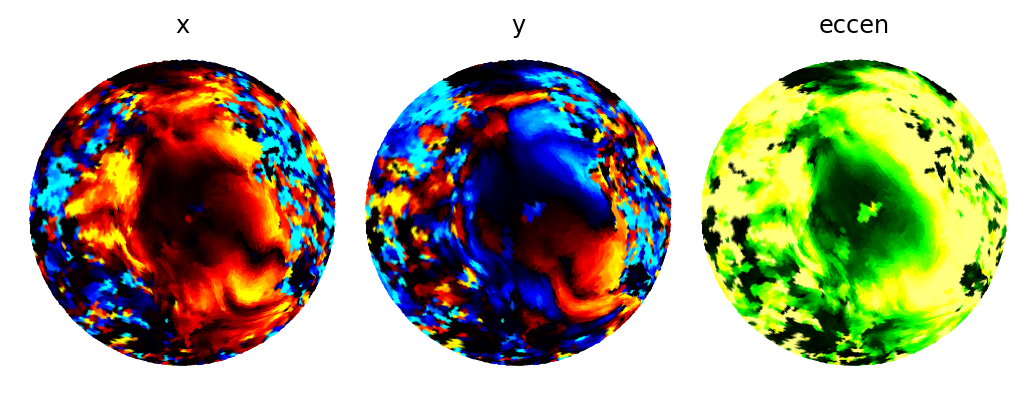

In [7]:
# Let's go ahead and plot the x, y, and eccentricity values.

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,3, figsize=(7,7/3), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)
for (ax,p,name) in zip(axs, [x,y,eccen], ['x','y','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
ny.cortex_plot(fmap, underlay=None, color=x, axes=axs[0],
               cmap='temperature_dark', vmin=-7, vmax=7)
ny.cortex_plot(fmap, underlay=None, color=y, axes=axs[1],
               cmap='temperature_dark', vmin=-7, vmax=7)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[2],
               cmap='greenish_dark', vmin=0, vmax=7)

pass

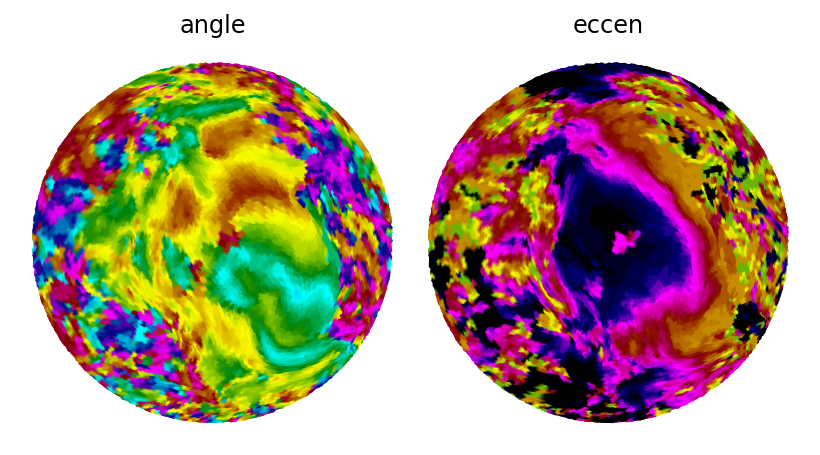

In [8]:
# The borders are generally easier to see when we plot the polar
# angle and eccentricity.

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)
for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)
pass

### A Reasonable Starting Guess

In order to begin any procedure that attempts to solve the labeling problem, we will likely need a reasonable guess from which to start a search. We can use the anatomical template of retinotopy to do this.

In [9]:
pred = ny.vision.predict_retinotopy(hemi)

angle0 = pred['angle']
eccen0 = pred['eccen']
label0 = pred['varea']

# These are for the whole hemisphere, so we take the verrtices
# that are in the fmap only.
(angle0, eccen0, label0) = [np.array(prop[fmap.labels])
                            for prop in (angle0, eccen0, label0)]

# Convert to x and y.
th0 = np.pi/180 * (90 - angle0)
x0 = eccen0 * np.cos(th0)
y0 = eccen0 * np.sin(th0)
xy0 = np.transpose([x0,y0])
# Good to convert to float32 also.
(th0,x0,y0,xy0) = [q.astype('float32') for q in (th0,x0,y0,xy0)]

# We should limit the initial label predictions to the max_eccen.
label0[eccen0 > max_eccen] = 0
# We also want only V1, V2, and V3 labels (as well as blanks, 0).
label0[~np.isin(label0, [0,1,2,3])] = 0

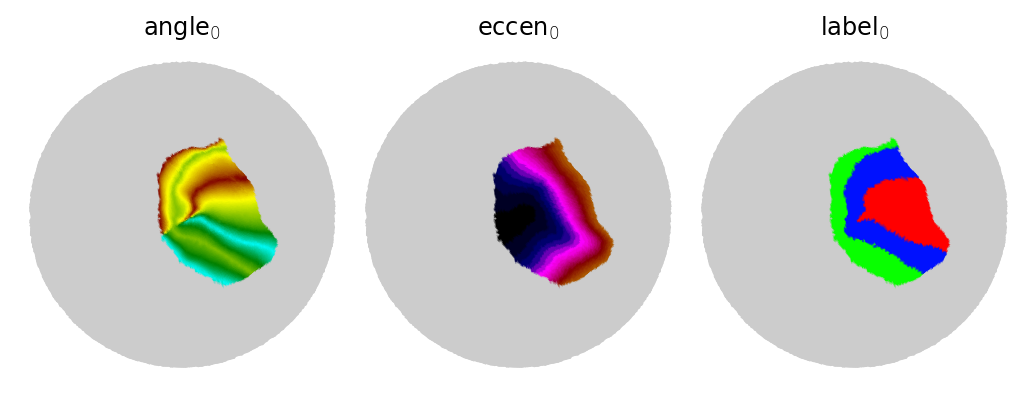

In [10]:
# Let's plot these labels with the polar angle and eccentricity maps.
# These are predicted maps based on anatomy, so are not necessarily
# accurate for the subjet we are looking at.

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,3, figsize=(7,7/3), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)
for (ax,name) in zip(axs, [r'angle$_0$',r'eccen$_0$',r'label$_0$']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
mask = (label0, (1,2,3))
ny.cortex_plot(fmap, underlay='0.8', color=angle0, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180, mask=mask)
ny.cortex_plot(fmap, underlay='0.8', color=eccen0, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90, mask=mask)
ny.cortex_plot(fmap, underlay='0.8', color=label0, axes=axs[2],
               cmap=ny.graphics.label_cmap(label0), mask=mask)
pass

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


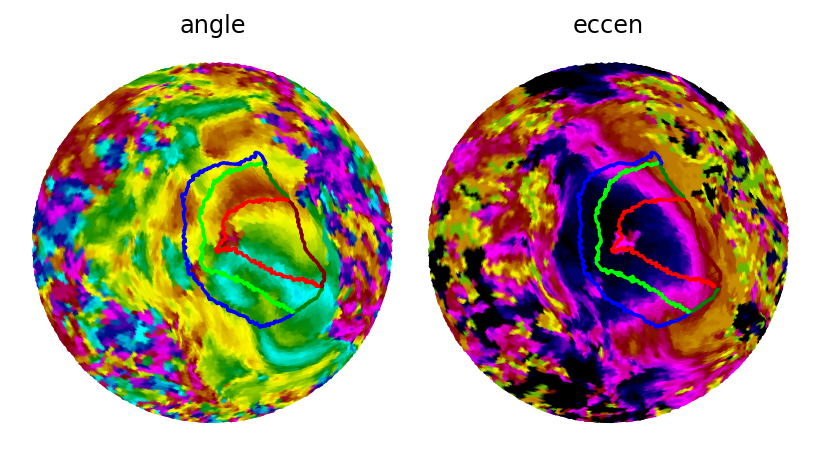

In [11]:
# We might also want to be able to plot the boundaries of the V1/V2/V3
# areas on the actual measued visual field coordinates:

# To plot where the label boundaries are, we plot points in the middle
# of the edges that straddle the boundaries. We can plot them in 
# different colors for different boundaries:
boundary_colors = {(1,2): (1,0,0), (0,1): (0.5,0,0),
                   (2,3): (0,1,0), (0,2): (0,0.5,0),
                   (0,3): (0,0,1)}
boundary = label0[u] != label0[v]
boundary_u = u[boundary]
boundary_v = v[boundary]
boundary_lbl = [tuple(sorted([label0[uu], label0[vv]]))
                for (uu,vv) in zip(boundary_u, boundary_v)]
boundary_clr = [boundary_colors[lbl] for lbl in boundary_lbl]
boundary_coords = np.mean([fmap.coordinates[:,boundary_u],
                           fmap.coordinates[:,boundary_v]],
                          axis=0)

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)

for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.scatter(boundary_coords[0], boundary_coords[1],
               c=boundary_clr, s=0.5)
pass

## Approach 1. Random Walk

The idea behind the random-walk approach is that we can randomly permute the vertices along the label boundaries then re-evaluate them according to a score that represents our constraints.

A simple approach, in which we first construct a score function then run a random search using it, is detailed here.

### The Score Function

In [12]:
from numba import jit

The score function $f$ should take as input the set of hypothesized labels $\mathbf{\lambda}$ and yield an objective score $f(\mathbf{\lambda}) = z$ that we believe is large when the labels are a poor match to our constraints and small when the labels are a good match. As we randomly permute labels, we will use this score to determine if we are improving the predicted labels or not.

Because we are going to be searching with it, we want to be able to define $f$ to run very efficiently; accordingly, we'll do two things:
1. We'll use the the numba library to jit-optimize the parts of our scoring function
2. We'll define functions that calculate the change in the scoring function that results from a change in the labels; this way when we change a single label, we won't have to completely recalculate the score.

In [119]:
from numba import jit

@jit('float32(float32[:], float32[:])')
def score_xdist(xy1, xy2):
    '''
    score_xdist(xy1, xy2) yields the score value for a pair of vetices that straddle
      a boundary known to correspond to the x-axis, such as the V2-V3 boundary.
    '''
    return xy1[1]**2 + xy2[1]**2 + (xy1[1] - xy2[1])**2
@jit('float32(float32[:], float32[:])')
def score_ydist(xy1, xy2):
    '''
    score_ydist(xy1, xy2) yields the score value for a pair of vetices that straddle
      a boundary known to correspond to the y-axis, such as the V1-V2 boundary.
    '''
    return xy1[0]**2 + xy2[0]**2 + (xy1[0] - xy2[0])**2
@jit('float32(float32[:], float32[:], float32)')
def score_eccdist(xy1, xy2, maxecc):
    '''
    score_eccdist(xy1, xy2, maxecc) yields the score value for a pair of vetices
      that straddle a boundary known to correspond to the max-eccentricity (or
      outer stimulus boundary) such as the V1-, V2-, and V3-peripheral boundaries.
    '''
    ecc1 = np.sqrt(xy1[0]**2 + xy1[1]**2)
    ecc2 = np.sqrt(xy2[0]**2 + xy2[1]**2)
    return ((ecc1 - maxecc)**2 + (ecc2 - maxecc)**2 + (ecc1 - ecc2)**2)
@jit('float32(int64, int64, float32[:], float32[:], float32)', nopython=True)
def score_pair(lbl1, lbl2, xy1, xy2, maxecc):
    '''
    score_pair(lbl1, lbl2, xy1, xy2, maxecc) yields the score of an edge whose
      endpoints have lbl1 and lbl2 and are at visual (x,y) coordinates xy1 and xy2.
    '''
    # There's no score for labels that are the same.
    if   lbl1 == lbl2: return 0
    # To make things easier, make sure lbl1 <= lbl2.
    if lbl2 < lbl1: (lbl1,lbl2,xy1,xy2) = (lbl2,lbl1,xy2,xy1)
    if lbl1 == 0:
        if   lbl2 == 1: return score_eccdist(xy1, xy2, maxecc)
        elif lbl2 == 2: return score_eccdist(xy1, xy2, maxecc)
        else:
            s1 = score_eccdist(xy1, xy2, maxecc)
            s2 = score_ydist(xy1, xy2)
            return s1 if s1 < s2 else s2
    elif lbl1 == 1:
        if lbl2 == 2: return score_ydist(xy1, xy2)
        else: return np.inf # V1 and V3 should not touch 
    else: return score_xdist(xy1, xy2) # V2-V3
@jit('Tuple((float32, int64))(int64[:], int64[:], float32[:,:], int64, int64, float32)')
def score_pair_change(nei, lbl, xy, a, newlbl, maxecc):
    '''
    score_pair_change(nei, lbls, xy, a, newlbl, maxecc) yields the change
      in score that will occur for changing vertex a from its current label,
      given by lbls[a], to newlbl.
      
    The change in score is yielded as (delta_score, delta_edges) where the
    delta_score is the change in the scoring function as defined by
    score_pair and the delta_edges is the change in the number of edges
    that straddle the boundaries.
    
    If the change in score is not valid (i.e., if the change causes V1 to
    border V3) then (inf, 0) is returned.
      
    The nei and xy parameters are the adjacent vertices to a and the visual
    field coordinate of a, respectively.
    '''
    # score for changing lbl[a] into newlbl
    la = lbl[a]
    if la == newlbl: return (0, 0)
    delta_sc = 0
    delta_bs = 0
    xy_a = xy[a]
    for u in nei:
        lu = lbl[u]
        xy_u = xy[u]
        if la != lu: delta_sc -= score_pair(la, lu, xy_a, xy_u, maxecc)
        tmp = score_pair(newlbl, lu, xy_a, xy_u, maxecc)
        # If the score is infinite, we know that this isn't really a valid
        # change, so return infinity to indicate this.
        if not np.isfinite(tmp): return (np.inf, 0)
        delta_sc += tmp
        if la == lu:
            # it used to have 0 score; now it has a positive one
            delta_bs += 1
        elif newlbl == lu:
            # it used to have some positive score, now has a 0
            delta_bs -= 1
    return (delta_sc, delta_bs)
def score_pair_search(nei, lbl, xy, aa, newlbls, maxecc):
    '''
    score_pair_search(nei, lbls, xy, a, newlbl, maxecc) is exactly like score_pair_change
      except that instead of accepting a single vertex a and a single new label, it accepts
      a vector of each and yields (delta_score, delta_boundary, ii) where ii is the index
      into a and newlbl of the vertex with the lowest score. Additionally, the nei
      argument must be the entire list of neighborhoods.
    '''
    min_ii = 0
    min_sc = np.inf
    min_bs = 0
    for (ii,(a,newlbl)) in enumerate(zip(aa, newlbls)):
        (dsc,dbs) = score_pair_change(nei[a], lbl, a, newlbl, maxecc)
        if dsc < min_sc:
            min_sc = dsc
            min_bd = dbs
            min_ii = ii
    return (min_sc, min_bs, min_ii)

def score_labels(u, v, labels, xys, maxecc=7.0, boundary_weight=0.0, pair_weight=1.0):
    '''
    score_labels(u, v, labels, xys) yields the total score of the given set of 
      labels using the given set of edges (u,v) and the visual-field coordinates
      in the (n x 2) matrix xys.
      
    The optional parameters boundary_weight (default 0) and pair_weight (default
    1) can be set to change how the score considers the boundary length versus
    the sum of the pair-wise boundary-edge scores. The total score returned is
    the sum of score_pair for all edges times the pair_weight plus the length
    of the boundary (the number of edges on the boundary) times the
    boundary_weight.
    '''
    xys = np.asarray(xys).astype('float32')
    if xys.shape[1] != 2: xys = xys.T
    ii = np.where(labels[u] != labels[v])[0]
    sc = 0
    for (uu,vv) in zip(u[ii], v[ii]):
        sc += score_pair(labels[uu], labels[vv], xys[uu], xys[vv], maxecc)
    return (pair_weight*sc + boundary_weight*len(ii))
def score_change(neis, labels, xys, a, newlbl,
                 maxecc=7.0, boundary_weight=0.0, pair_weight=1.0):
    '''
    score_change(neis, labels, xys, a, newlbl) yields the change in score that
      results from changing the label for vertex a from labels[a] to newlbl.
      
    The argument neis must be a tuple of values (one value per vertex) such
    that each value nei[u], associated with vertex u, is itself a tuple of
    the vertices adjacent to vertex u in the vertex-edge graph. A data
    structure like this can be obtained from a cortical tesselation object
    via tess.indexed_neighborhoods.
      
    The optional aguments maxecc (default: 7), bounday_weight (default: 0),
    and pair_weight (default: 1) may be given and are handled as in
    score_labels, above.
    '''
    xys = np.asarray(xys).astype('float32')
    if xys.shape[1] != 2: xys = xys.T
    (delta_pair, delta_bound) = score_pair_change(np.asarray(neis[a]), labels, xys, a, newlbl, maxecc)
    return (pair_weight * delta_pair + boundary_weight * delta_bound)

In [120]:
# An example: score the starting guess labels.
score0 = score_labels(u, v, label0, xy)
score0

5762.975262248642

In [121]:
# What is the change if we swap label 100 to a 0?
nei = fmap.tess.indexed_neighborhoods
delta_sc = score_change(nei, label0, xy, 100, 0)
delta_sc

537.6851806640625

### The Random Walk

The random walk itself is relatively simple to implement. Starting with our initial labels $\mathbf{\lambda}$, we permute the labels in steps. At each step in the walk we do the following:

1. Pick an edge along the boundary at random.
2. Pick one of the two vertices at random (let $u$ be the picked vetex and $v$ be the other).
3. Calculate the change in score $\Delta s$ that results from changing $\lambda_u$ into $\lambda_v$.
4. If $\Delta s > 0$ then accept the step with some probability $p_{-}$, otherwise reject it; if $\Delta s < 0$ then accept the step with some probability $p_{+}$ or reject it.

Typically $p_{-}$ will be very low ($< 0.1$) while $p_{+}$ will be very high ($> 0.9$). Increasing $p_{-}$ adds noise to the system and can potentially be used to escape local minima, e.g. in a [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) strategy.

In [122]:
import random

def boundary_update(nei, labels, u, newlbl, boundary):
    '''
    We keep track of the boundary during a random walk with a set object; in order to
    update that object, we call boundary_update(nei, labels, u, newlbl, boundary),
    which adds/removes all necessary edge-pairs due to the change.
    '''
    oldlbl = labels[u]
    if oldlbl == newlbl: return boundary
    for v in nei:
        lv = labels[v]
        if   oldlbl == lv: boundary.add((u,v) if u < v else (v,u))
        elif newlbl == lv: boundary.remove((u,v) if u < v else (v,u))
    return boundary
def boundary_set(u, v, labels):
    '''
    boundary_set(u, v, labels) yields a new boundary-set containing all the boundary
      edges in the given set of edges defined by (u, v) for the given labels.
    '''
    ii = np.where(labels[u] != labels[v])[0]
    return set([(a,b) if a < b else (b,a) for (a,b) in zip(u[ii], v[ii])])
def autolabel_random_step(tess, labels, xys, p_good=1.0, p_bad=0.01,
                          maxecc=7, best_of=1, boundary=None,
                          boundary_weight=0, pair_weight=1):
    '''
    autolabel_random_step(tess, labels, xys) performs a single random step in
      place on the given labels which are associated with the given
      tesselation (or mesh) object tess and the given visual-field positions
      xys. The return value is the change in score if a change was made and
      None if a change was not made.
      
    Note that running random step often does not result in a change because
    the randomly-drawn change was subsequently rejected. Rejection is
    determined by the optional arguments p_good and p_bad (below) as well as
    the best_of option.
      
    The following optional arguments are accepted:
      * p_good (default: 1) determines the probability of accepting a
        randomly-generated change to the labels, given that the overall
        score function goes down due to the change. Since we are trying
        to minimize the score, this should generally be high.
      * p_bad (default: 0.01) determines the probability of accepting a
        randomly-generated change to the labels, given tha the overall
        score function goes up due to the change. Since we are trying to
        minimize the score, this should generally be low.
      * maxecc (default: 7) determines the maximum eccentricity value to
        use when scoring the labels.
      * best_of (default: 1) may be set to a positive integer n > 1 in order
        to, instead of generating just 1 random label change, generate n
        random changes and to use the one with the lowest score.
      * boundary (default: None) specifies the boundary set; passing this
        to random_step for throughout a minimization will increase speed.
      * boundary_weight (default: 0) and pair_weight (default: 1) specify
        the relative weights of the boundary-length and pair-wise score
        components of the score function.
    '''
    # in case a mesh/hemi was passed instead of a tesselation
    if not ny.is_tess(tess): tess = tess.tess
    neis = tess.indexed_neighborhoods
    # make a boundary if none exists
    if boundary is None:
        (u,v) = tess.indexed_edges
        boundary = boundary_set(u, v, labels)
    # pick some of the edges in the boundary at random
    if best_of > 1:
        es = random.sample(boundary, best_of)
        qs = np.random.rand(best_of) > 0.5
        scores = [score_change(neis, labels, xys,
                               u if q else v, labels[v if q else u],
                               maxecc=maxecc, 
                               boundary_weight=boundary_weight,
                               pair_weight=pair_weight)
                  for ((u,v),q) in zip(es, qs)]
        ii = np.argmin(scores)
        (dsc, (u,v), q) = (scores[ii], es[ii], qs[ii])
        (w,z) = (u,v) if q else (v,u)
    else:
        (u,v) = random.sample(boundary, 1)[0]
        q = np.random.rand() > 0.5
        (w,z) = (u,v) if q else (v,u)
        dsc = score_change(neis, labels, xys, w, labels[z], maxecc=maxecc, 
                           boundary_weight=boundary_weight, pair_weight=pair_weight)
    if not np.isfinite(dsc): return 0
    p = p_good if dsc < 0 else p_bad
    # If we fail this draw, we reject the proposed change.
    if np.random.rand() > p: return None
    # Otherwise we implement it.
    oldlbl = labels[w]
    newlbl = labels[z]
    if oldlbl == newlbl: return 0 # (shouldn't ever happen)
    boundary_update(nei[w], labels, w, newlbl, boundary)
    labels[w] = newlbl
    return dsc
def autolabel_anneal(tess, labels, xys, nsteps=250000,
                     maxecc=7, boundary_weight=0, pair_weight=1,
                     annealing_speed=8, max_best_of=5):
    '''
    autolabel_anneal(tess, labels, xys) runs a single round of simulated annealing
      on the given tesselation (or mesh) tess, the given labels, and the given
      visual-field coordiantes xys. The return value is the new score; changes to
      the labels are made in-place.
      
    During annearling, the "temperature" of the steps begins at a very high level
    and drops steadily. This is achieved by altering the probability of accepting
    a label-change that has a positive score-change (p_bad) while holding the
    probability of accepting a label-change that has a negative score-change
    (p_good) constant at 1. For a step k, p_bad is set to exp(-s f) where s is
    the optional parameter annealing_speed and f = k/(nsteps-1). Additionally,
    the best_of parameter to the random_label_step is gradually decreased from
    max_best_of to 1 at a similar rate
      
    The following options are accepted:
      * nsteps (default: 250,000) specifies the numbe of steps in the annealing
        process.
      * maxecc (default: 7) specifies the maximum eccentricity to include in the
        labels.
      * boundary_weight (default: 0) and pair_weight (default: 1) specify the
        weights of the boundary-based and pair-based component of the scoring
        function.
      * annealing_speed (default: 8) specifies the speed at which the annealing
        takes place. Higher numbers cool the simulation faster.
    '''
    # If tess is actually a mesh or hemisphere, get the tess object.
    if not ny.is_tess(tess): tess = tess.tess
    (u,v) = tess.indexed_edges
    # If there's a boundary_weight, make a boundary.
    if boundary_weight == 0: boundary = None
    else: boundary = boundary_set(u, v, labels)
    # Make sure the given parameters are reasonable.
    assert annealing_speed > 0, 'annealing_speed must be a positive number'
    assert max_best_of >= 1, 'max_best_of must be greater than 1'
    # We will keep track of the best score/labels so far.
    min_score = np.inf
    min_labels = np.array(labels)
    # Calculate the initial score.
    score = score_labels(u, v, labels, xys, maxecc=maxecc,
                         boundary_weight=boundary_weight,
                         pair_weight=pair_weight)
    # Run the steps:
    for (k,f) in enumerate(np.linspace(0, 1, nsteps)):
        # Figure out our random_label_step parameters for this step:
        pbad = np.exp(-annealing_speed * f)
        bo = np.exp(-annealing_speed * (1 - f))
        bo = int(np.ceil(max_best_of*bo))
        # Run a random step:
        dsc = autolabel_random_step(tess, labels, xys,
                                    maxecc=maxecc, boundary=boundary,
                                    p_good=1, p_bad=pbad, best_of=bo,
                                    boundary_weight=boundary_weight,
                                    pair_weight=pair_weight)
        if dsc is None: continue # No step was taken (change rejected).
        score += dsc
        if score < min_score:
            # New lowest score!
            min_score = score
            min_labels[:] = labels
    # We've run all the steps; now just set the labels to the min-scored labels that
    # we found during the search and return the final score.
    labels[:] = min_labels
    return min_score

#### Test the Annealing Functions

In [123]:
# Test the autolabel_anneal() function.
nsteps = 10000
# Copy the initial labels.
label = np.array(label0)
t0 = time.time() # start time
score = autolabel_anneal(fmap, label, xy, nsteps=nsteps)
t1 = time.time() # end time

# Print a message about the time elapsed:
dt = t1 - t0
m = int((dt - np.mod(dt, 60)) / 60)
s = dt - m*60
msperstep = dt / nsteps * 1000
print('%d steps taken in %dm, %05.2fs (%05.3f ms / step).' % (nsteps, m, s, msperstep))

10000 steps taken in 0m, 20.73s (2.073 ms / step).


/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


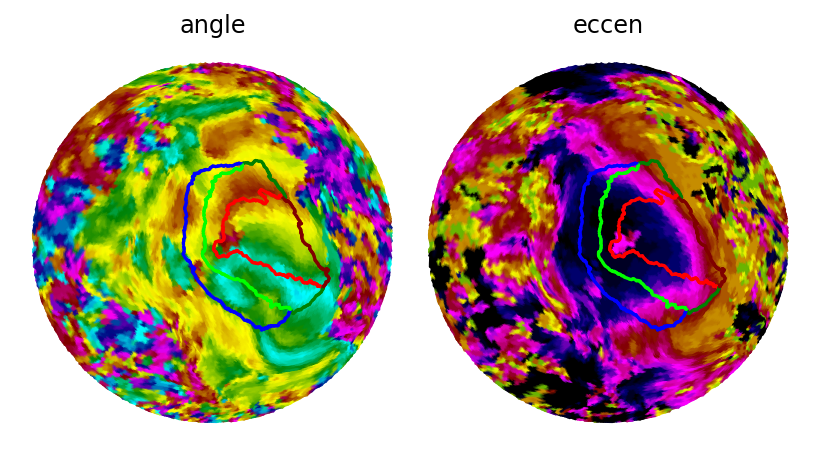

In [124]:
# Plot the result of the above steps:
boundary = label[u] != label[v]
boundary_u = u[boundary]
boundary_v = v[boundary]
boundary_lbl = [tuple(sorted([label[uu], label[vv]]))
                for (uu,vv) in zip(boundary_u, boundary_v)]
boundary_clr = [boundary_colors[lbl] for lbl in boundary_lbl]
boundary_coords = np.mean([fmap.coordinates[:,boundary_u],
                           fmap.coordinates[:,boundary_v]],
                          axis=0)

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)

for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.scatter(boundary_coords[0], boundary_coords[1],
               c=boundary_clr, s=0.5)
pass

### Execute the Random-Walk Using Simulated Annealing

At this point, we have defined a scoring function as well as a function for running random steps of a minimization and for performing simulated annealing using this random-step function. Because this is fundamentally a random search, we will need to run a lot of steps to find a good solution. To speed things up, we can run several processes of simulated annealing at once using the sharedmem package.

In [127]:
import multiprocessing

# The number of annealing jobs/cpus to use.
nprocs = multiprocessing.cpu_count()
# The number of simulated-annealing rounds to run.
nrounds = 4
# The number of steps in each round.
nsteps = 50000
# The annealing speed.
annealing_speed = 2
# The max best_of value.
max_best_of = 1
# The boundary is ramped up over the annealing rounds to this value. 
max_boundary_weight = 0.5
# The max eccentricity.
maxecc = 7.0

# Before we start, we want to convert xy to be on a log-scale; this is
# because eccentricity is exponentially-spaced in the visual field
# relative to its spacing on cortex, so this generally improves the
# ability of the minimizations to deal with low-eccentricity values.
logxy = ny.to_logeccen(xy)
logmaxecc = ny.to_logeccen(maxecc)

# We keep the pair_weight as 1 at all times
pair_weight = 1

# We will keep track of the minimum label configuration we've found as we go.
(u,v) = fmap.tess.indexed_edges
min_score = score_labels(u, v, label0, logxy, maxecc=logmaxecc,
                         boundary_weight=0, pair_weight=pair_weight)
init_score = min_score
min_label = np.array(label0)
# We define this function for the annealing processes to run:
def anneal_job(boundary_weight):
    labels = np.array(min_label)
    score = autolabel_anneal(fmap, labels, logxy, nsteps=nsteps,
                             annealing_speed=annealing_speed,
                             max_best_of=max_best_of, maxecc=logmaxecc,
                             boundary_weight=boundary_weight,
                             pair_weight=pair_weight)
    return (score, labels)
# We are going to run a number of parallel annealing rounds.
t0 = time.time()
for roundno in range(nrounds):
    # Recalculate the boundary weight for this annealing round.
    boundary_weight = roundno * max_boundary_weight / (nrounds-1)
    # because we've changed the boundary_weight, we need to recalculate the min score
    min_score = score_labels(u, v, min_label, logxy, maxecc=logmaxecc,
                             boundary_weight=boundary_weight,
                             pair_weight=pair_weight)
    score0 = min_score
    # Print a progress message.
    print('Running parallel-annealing round %d (initial score: %f)...' % (roundno+1, min_score))
    # In parallel, we do the simulated annealing
    with multiprocessing.Pool(nprocs) as pool:
        results = pool.map(anneal_job, [boundary_weight]*nprocs)
    # Of the results, which did the best?
    for (score,labels) in results:
        if score >= min_score: continue
        min_score = score
        min_label[:] = labels
    print('  %d annealing jobs finished with score change of %05.2f%%' % (
        nprocs, (min_score - score0) / score0 * 100))
t1 = time.time()

# Print a message about elapsed time.
dt = t1 - t0
m = int((dt - np.mod(dt, 60)) / 60)
s = dt - 60*m
nstepstot = (nprocs * nsteps * nrounds) * 1000
msperstep = dt / nstepstot
print()
print('%d steps taken in %dm, %05.2fs (%05.3f ms / step).' % (nstepstot, m, s, msperstep))
dscore = min_score - init_score
print('Score Change: %f (%05.3f per second; %05.3f per step).' % (dscore, dscore/dt, dscore/nstepstot))

Running parallel-annealing round 1 (initial score: 39.268449)...
  3 annealing jobs finished with score change of -63.42%
Running parallel-annealing round 2 (initial score: 182.696524)...
  3 annealing jobs finished with score change of -11.93%
Running parallel-annealing round 3 (initial score: 310.226167)...
  3 annealing jobs finished with score change of -7.47%
Running parallel-annealing round 4 (initial score: 425.225416)...
  3 annealing jobs finished with score change of 00.00%

600000000 steps taken in 4m, 07.01s (0.000 ms / step).
Score Change: 385.956967 (1.563 per second; 0.000 per step).


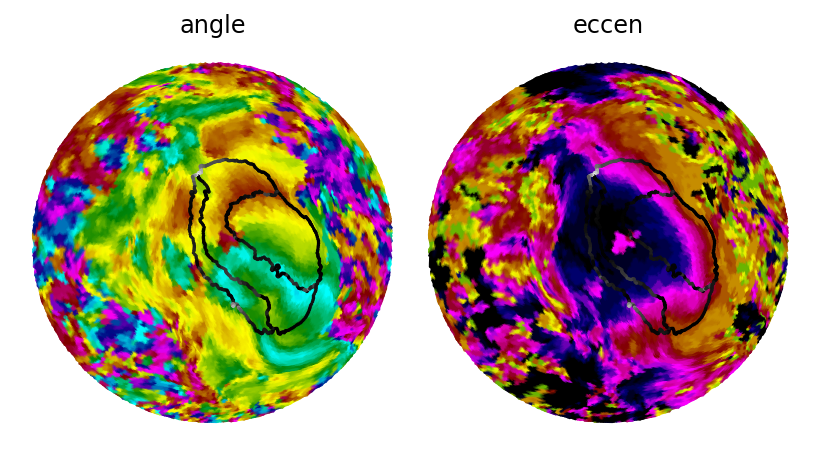

In [128]:
# Plot the result of the above steps:
boundary = min_label[u] != min_label[v]
boundary_u = u[boundary]
boundary_v = v[boundary]
boundary_lbl = [tuple(sorted([label[uu], label[vv]]))
                for (uu,vv) in zip(boundary_u, boundary_v)]
boundary_coords = np.mean([fmap.coordinates[:,boundary_u],
                           fmap.coordinates[:,boundary_v]],
                          axis=0)

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)

for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    # color the points by their pairwise scores
    clrs = [score_pair(min_label[uu], min_label[vv], logxy[uu], logxy[vv], logmaxecc)
            for (uu,vv) in zip(boundary_u, boundary_v)]
    ax.scatter(boundary_coords[0], boundary_coords[1],
               c=clrs, s=0.5, cmap='gray')

pass